# Forecast Model Comparison 

Source DL models: https://pure.tudelft.nl/ws/portalfiles/portal/43646098/1_s2.0_S030626191830196X_main.pdf

## 1. Load Data

In [27]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Connect to the SQLite database (if the database doesn't exist, it will be created)
conn = sqlite3.connect('Main_DB')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Your SQL query
temp_df = '''
SELECT * from wind
'''

# Read SQL query result into a DataFrame
wind = pd.read_sql_query(temp_df, conn)
wind.rename(columns={'value': 'wind_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from spot_price
'''

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)
spot_price.rename(columns={'value': 'spot_price'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from solar
'''

# Read SQL query result into a DataFrame
solar = pd.read_sql_query(temp_df, conn)
solar.rename(columns={'value': 'solar_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from demand
'''

# Read SQL query result into a DataFrame
demand = pd.read_sql_query(temp_df, conn)
demand.rename(columns={'value': 'demand'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from nuclear
'''

# Read SQL query result into a DataFrame
nuclear = pd.read_sql_query(temp_df, conn)
nuclear.rename(columns={'value': 'nuclear_generation'}, inplace=True)

# SQL query
temp_df = '''
SELECT * from gas_data
'''

# Read SQL query result into a DataFrame
gas_data = pd.read_sql_query(temp_df, conn)
gas_data.rename(columns={'value': 'gas_price'}, inplace=True)
gas_data_hourly = gas_data.reindex(gas_data.index.repeat(24)).reset_index(drop=True)

# Close the connection
conn.close()

# Display the DataFrame


Create original df

In [28]:
df=wind.merge(spot_price, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(solar, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(demand, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(nuclear, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(gas_data, left_on=['day'], right_on=['delivery_day'])\
        .drop('delivery_day', axis=1)

df.head(5)

,wind_generation,day,hour,spot_price,solar_generation,demand,nuclear_generation,index_price
0,3214.0,2019-01-01,01:00,66.88,0.0,23753.0,6071.9,24.45
1,3222.0,2019-01-01,02:00,66.88,0.0,23018.0,6071.9,24.45
2,3081.0,2019-01-01,03:00,66.00,0.0,21808.0,6071.9,24.45
3,3069.0,2019-01-01,04:00,63.64,0.0,20635.0,6071.9,24.45
4,2973.0,2019-01-01,05:00,58.85,0.0,19824.0,6071.9,24.45


In [29]:
low_bidding_price = ['solar_generation', 'wind_generation', 'nuclear_generation']
renewable = ['solar_generation', 'wind_generation']

# Create a new column based on the condition
df['covered_renewables'] = (df[renewable].sum(axis=1) > df['demand']).astype(int)
df['covered_low_price'] = (df[low_bidding_price].sum(axis=1) > df['demand']).astype(int)

df = df.dropna()


In [4]:
X = df[['wind_generation', 'solar_generation', 'demand', 'index_price', 'nuclear_generation', 'covered_renewables', 'covered_low_price']]
y = df['spot_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [5]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [34]:
df.to_csv('market_data.csv', header=True)


In [32]:
df.columns

Index(['wind_generation', 'day', 'hour', 'spot_price', 'solar_generation',
       'demand', 'nuclear_generation', 'index_price', 'covered_renewables',
       'covered_low_price'],
      dtype='object')

In [7]:
results = pd.DataFrame()

## 1. Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [22]:
# Calculate MSE and MAE
mse_lr = mean_squared_error(y_test, pred_reg)
mae_lr = mean_absolute_error(y_test, pred_reg)

# New row to be added
lr_results = {'model': 'Linear Regression', 'MSE': mse_lr, 'MAE': mae_lr}

# Specify the new row directly
results = results.append(lr_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_139820\396656799.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(lr_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516


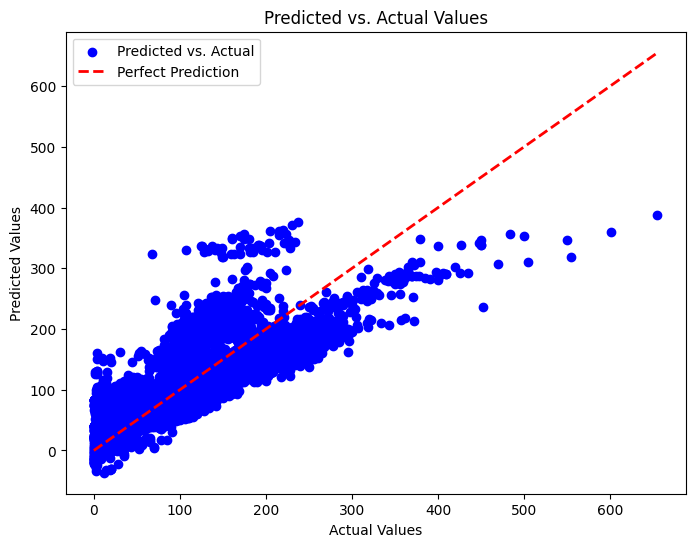

In [23]:
# Plotting the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_reg, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()


## 2. CART

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

regressor = DecisionTreeRegressor(random_state=42, min_samples_split=50)
regressor.fit(X_train, y_train)

# Predict on the test set
pred_CART = regressor.predict(X_test)



In [25]:
# Calculate MSE and MAE
mse_CART = mean_squared_error(y_test, pred_CART)
mae_CART = mean_absolute_error(y_test, pred_CART)

# New row to be added
CART_results = {'model': 'CART', 'MSE': mse_CART, 'MAE': mae_CART}

# Specify the new row directly
results = results.append(CART_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_139820\2462508764.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(CART_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516
1,CART,422.942127,11.142663


## 3. XGBOOST

In [26]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Define XGBoost regressor
reg = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],  
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)



Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}


In [27]:
reg_best_parameters = xgb.XGBRegressor(colsample_bytree = best_params['colsample_bytree'],\
                                       learning_rate = best_params['learning_rate'],\
                                       max_depth = best_params['max_depth'],\
                                       n_estimators = best_params['n_estimators'],\
                                       subsample = best_params['subsample'])

In [28]:
xg_model = reg_best_parameters.fit(X_train, y_train)

pred_xgboost = xg_model.predict(X_test)

In [29]:
# Calculate MSE and MAE
mse_XG = mean_squared_error(y_test, pred_xgboost)
mae_XG = mean_absolute_error(y_test, pred_xgboost)

# New row to be added
XG_results = {'model': 'XGBoost', 'MSE': mse_XG, 'MAE': mae_XG}

# Specify the new row directly
results = results.append(XG_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_139820\815242773.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(XG_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516
1,CART,422.942127,11.142663
2,XGBoost,337.675163,10.724308


In [30]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from scipy.stats import uniform

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Define AdaBoost regressor with DecisionTreeRegressor as the base estimator
reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

# Define the hyperparameter distributions to search
param_dist = {
    'n_estimators': [50, 100, 200, 300],  
    'learning_rate': uniform(0.01, 0.2 - 0.01),  
    'loss': ['linear', 'square', 'exponential'],  
    'base_estimator__max_depth': [1, 2, 3],  # Decision tree depth
    'base_estimator__min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'base_estimator__min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=reg, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)

# Optionally, you can evaluate the performance of the best estimator on your data
# For example:
# predictions = best_estimator.predict(X)
# mse = mean_squared_error(y, predictions)
# print("Mean Squared Error:", mse)


C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` 

Best Parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 10, 'learning_rate': 0.028995234005420548, 'loss': 'exponential', 'n_estimators': 300}


In [31]:
pred_ADA = best_estimator.predict(X_test)

In [32]:
# Calculate MSE and MAE
mse_ADA = mean_squared_error(y_test, pred_ADA)
mae_ADA = mean_absolute_error(y_test, pred_ADA)

# New row to be added
ADA_results = {'model': 'ADABoost', 'MSE': mse_ADA, 'MAE': mae_ADA}

# Specify the new row directly
results = results.append(ADA_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_139820\1697947124.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(ADA_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516
1,CART,422.942127,11.142663
2,XGBoost,337.675163,10.724308
3,ADABoost,1155.999840,22.890598


# 4. DNN

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [1, 3],
    'model__neurons_1': [10, 20],
    'model__neurons_2': [15, 10],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['accuracy']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=0)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


Epoch 1/50
1102/1102 [==============================] - 1s 870us/step - loss: 13892646.0000
Epoch 2/50
1102/1102 [==============================] - 1s 841us/step - loss: 255794.8125
Epoch 3/50
1102/1102 [==============================] - 1s 830us/step - loss: 80562.9219
Epoch 4/50
1102/1102 [==============================] - 1s 894us/step - loss: 27232.5703
Epoch 5/50
1102/1102 [==============================] - 1s 895us/step - loss: 12164.2939
Epoch 6/50
1102/1102 [==============================] - 1s 862us/step - loss: 8554.3066
Epoch 7/50
1102/1102 [==============================] - 1s 863us/step - loss: 7126.4727
Epoch 8/50
1102/1102 [==============================] - 1s 902us/step - loss: 6792.3545
Epoch 9/50
1102/1102 [==============================] - 1s 860us/step - loss: 6485.4897
Epoch 10/50
1102/1102 [==============================] - 1s 870us/step - loss: 6422.8501
Epoch 11/50
1102/1102 [==============================] - 1s 915us/step - loss: 6301.3555
Epoch 12/50
1102/1102

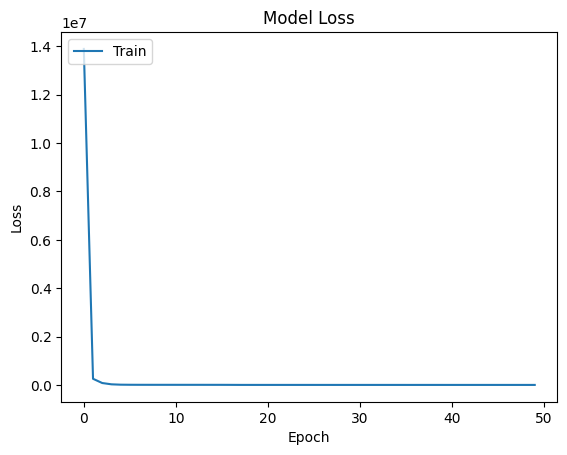

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the parameters grid
params = {
    'batch_size': 20,
}

# Function to create the neural network model
def create_model():
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=6, activation='relu', kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=0.1))
    nn.add(tf.keras.layers.Dense(units=4, activation='relu'))
    nn.add(tf.keras.layers.Dropout(rate=0.1))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer='adam',
               loss='mean_squared_error')  
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
history = model.fit(X_train, y_train, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)], verbose=1)

# Evaluate the model on test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)
print(history.history_.keys())
# Plot loss vs epoch
plt.plot(history.history_['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


In [26]:
# Calculate MSE and MAE
mse_DNN = mean_squared_error(y_test, y_pred)
mae_DNN = mean_absolute_error(y_test, y_pred)

# New row to be added
DNN_results = {'model': 'DNN', 'MSE': mse_DNN, 'MAE': mae_DNN}

# Specify the new row directly
results = results.append(DNN_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_131616\736844483.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(DNN_results, ignore_index=True)


,model,MSE,MAE
0,DNN,1642.802911,28.377677


In [10]:
y_pred

array([ 37.610428,  49.46883 ,  35.424896, ..., 154.44699 ,  40.39394 ,
        35.719254], dtype=float32)

In [8]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [1, 3],
    'model__neurons_1': [6, 7],
    'model__neurons_2': [4, 3],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['mean_absolute_error']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=1)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)



Fitting 10 folds for each of 128 candidates, totalling 1280 fits


C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan





1764/1764 [==============================] - 3s 1ms/step - loss: 397.4163 - mean_absolute_error: 397.4163
Best: nan using {'batch_size': 20, 'epochs': 1, 'model__activation': 'relu', 'model__dropout': 0.1, 'model__neurons_1': 6, 'model__neurons_2': 4, 'model__optimizer': 'adam'}
nan (nan) with: {'batch_size': 20, 'epochs': 1, 'model__activation': 'relu', 'model__dropout': 0.1, 'model__neurons_1': 6, 'model__neurons_2': 4, 'model__optimizer': 'adam'}
nan (nan) with: {'batch_size': 20, 'epochs': 1, 'model__activation': 'relu', 'model__dropout': 0.1, 'model__neurons_1': 6, 'model__neurons_2': 4, 'model__optimizer': 'rmsprop'}
nan (nan) with: {'batch_size': 20, 'epochs': 1, 'model__activation': 'relu', 'model__dropout': 0.1, 'model__neurons_1': 6, 'model__neurons_2': 3, 'model__optimizer': 'adam'}
nan (nan) with: {'batch_size': 20, 'epochs': 1, 'model__activation': 'relu', 'model__dropout': 0.1, 'model__neurons_1': 6, 'model__neurons_2': 3, 'model__optimizer': 'rmsprop'}
nan (nan) with

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [2, 3],
    'model__neurons_1': [6, 7],
    'model__neurons_2': [4, 3],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['mean_absolute_error']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=0)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

Epoch 1/50
40/40 [==============================] - 1s 1ms/step - loss: 105.1761 - mean_absolute_error: 105.1761
Epoch 2/50
40/40 [==============================] - 0s 1ms/step - loss: 105.1242 - mean_absolute_error: 105.1242
Epoch 3/50
40/40 [==============================] - 0s 947us/step - loss: 105.0484 - mean_absolute_error: 105.0484
Epoch 4/50
40/40 [==============================] - 0s 1000us/step - loss: 104.9320 - mean_absolute_error: 104.9320
Epoch 5/50
40/40 [==============================] - 0s 977us/step - loss: 104.8652 - mean_absolute_error: 104.8652
Epoch 6/50
40/40 [==============================] - 0s 970us/step - loss: 104.7206 - mean_absolute_error: 104.7206
Epoch 7/50
40/40 [==============================] - 0s 1ms/step - loss: 104.4824 - mean_absolute_error: 104.4824
Epoch 8/50
40/40 [==============================] - 0s 1ms/step - loss: 104.1365 - mean_absolute_error: 104.1365
Epoch 9/50
40/40 [==============================] - 0s 984us/step - loss: 103.7134 - me

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [50, 70],
    'model__neurons_1': [6, 7],
    'model__neurons_2': [4, 3],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['mean_absolute_error']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=0)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan



Epoch 1/50


40/40 [==============================] - 1s 2ms/step - loss: 105.0787 - mean_absolute_error: 105.0787
Epoch 2/50
40/40 [==============================] - 0s 1ms/step - loss: 104.9963 - mean_absolute_error: 104.9963
Epoch 3/50
40/40 [==============================] - 0s 1ms/step - loss: 104.8713 - mean_absolute_error: 104.8713
Epoch 4/50
40/40 [==============================] - 0s 1ms/step - loss: 104.7176 - mean_absolute_error: 104.7176
Epoch 5/50
40/40 [==============================] - 0s 1ms/step - loss: 104.4839 - mean_absolute_error: 104.4839
Epoch 6/50
40/40 [==============================] - 0s 1ms/step - loss: 104.2407 - mean_absolute_error: 104.2407
Epoch 7/50
40/40 [==============================] - 0s 1ms/step - loss: 103.9234 - mean_absolute_error: 103.9234
Epoch 8/50
40/40 [==============================] - 0s 1ms/step - loss: 103.4405 - mean_absolute_error: 103.4405
Epoch 9/50
40/40 [==============================] - 0s 1ms/step - loss: 102.7495 - mean_abso

In [ ]:
dnn_mae = mean_absolute_error(y_test, y_pred)
dnn_mae

28.097770927865362

In [ ]:
raw_url = 'https://github.com/adebu/market_data/blob/main/market_data.csv?raw=true'

# Read the .txt file into a DataFrame
df = pd.read_csv(raw_url, delimiter=' ')  # Assuming the file is tab-separated, adjust delimiter as needed

# Display the DataFrame
print(df)

      3214.0 2019-01-01 01:00 66.88 0.0 23753.0 6071.9 24.45 0 0
0      3222.0 2019-01-01 02:00 66.88 0.0 23018.0 6071...        
1      3081.0 2019-01-01 03:00 66.0 0.0 21808.0 6071....        
2      3069.0 2019-01-01 04:00 63.64 0.0 20635.0 6071...        
3      2973.0 2019-01-01 05:00 58.85 0.0 19824.0 6071...        
4      2904.0 2019-01-01 06:00 55.47 0.0 19544.0 6071...        
...                                                  ...        
88152  1717.3 2023-12-24 19:00 101.55 7.9 27428.5 711...        
88153  1943.5 2023-12-24 20:00 109.3 0.0 27998.0 7117...        
88154  1942.0 2023-12-24 21:00 109.3 0.0 27489.3 7117...        
88155  1836.0 2023-12-24 22:00 92.85 0.0 25901.0 7117...        
88156  1731.0 2023-12-24 23:00 76.93 0.0 23392.3 7117...        

[88157 rows x 1 columns]


In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': 20,
}

# Function to create the neural network model
def create_model(input_shape):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(input_shape,)))  
    nn.add(tf.keras.layers.Dense(units=6, activation='relu', kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=0.1))
    nn.add(tf.keras.layers.Dense(units=4, activation='relu'))
    nn.add(tf.keras.layers.Dropout(rate=0.1))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer='adam',
               loss='mean_squared_error')  # Use mean squared error for regression
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
input_shape = X_train.shape[1]  # Determine input shape

# Fit the model
model.fit(X_train, y_train, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)], verbose=1, input_shape=input_shape)

# Evaluate the model on test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


TypeError: create_model() missing 1 required positional argument: 'input_shape'